In [4]:
main_path = r"C:\Users\pirag\Documents\Projects\Pattern Project\Dataset"

Resize to 224x224 and creating labeling the subfolder images with the respect sub folder name and generating the dataframe

In [46]:
import os
import pandas as pd
from PIL import Image
import numpy as np

# Path to the dataset folder
main_path = r"C:\Users\pirag\Documents\Projects\Pattern Project\Dataset"

# List to hold the image data and their labels
image_data = []
labels = []

# Loop through the subfolders and images
for subfolder in os.listdir(main_path):
    subfolder_path = os.path.join(main_path, subfolder)
    
    # Check if it's a directory (subfolder)
    if os.path.isdir(subfolder_path):
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            
            # Check if it's an image file (you can expand this as needed)
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                # Open and resize the image to 224x224
                with Image.open(image_path) as img:
                    img_resized = img.resize((224, 224))
                    # Convert image to a numpy array
                    img_array = np.array(img_resized)
                    # Append image data and label to the lists
                    image_data.append(img_array)
                    labels.append(subfolder)

# Convert lists to DataFrame
df = pd.DataFrame({
    'image': image_data,
    'label': labels
})

# Show the dataframe
print(df.head())


                                               image                  label
0  [[[229, 215, 209], [228, 214, 208], [228, 213,...  Bacterial leaf blight
1  [[[227, 214, 208], [228, 213, 208], [231, 215,...  Bacterial leaf blight
2  [[[234, 219, 216], [232, 220, 216], [234, 220,...  Bacterial leaf blight
3  [[[236, 225, 220], [235, 224, 221], [236, 226,...  Bacterial leaf blight
4  [[[240, 232, 226], [239, 231, 227], [240, 230,...  Bacterial leaf blight


Encoding the labels as numerica label


In [47]:
import os
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder

# Path to the dataset folder
main_path = r"C:\Users\pirag\Documents\Projects\Pattern Project\Dataset"

# List to hold the image data and their labels
image_data = []
labels = []

# Loop through the subfolders and images
for subfolder in os.listdir(main_path):
    subfolder_path = os.path.join(main_path, subfolder)
    
    # Check if it's a directory (subfolder)
    if os.path.isdir(subfolder_path):
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            
            # Check if it's an image file
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                try:
                    # Open and resize the image to 224x224
                    with Image.open(image_path) as img:
                        img_resized = img.resize((224, 224))
                        # Convert image to a numpy array
                        img_array = np.array(img_resized)
                        # Append image data and label to the lists
                        image_data.append(img_array)
                        labels.append(subfolder)
                except UnidentifiedImageError:
                    print(f"Warning: Could not process file {image_path}")

# Encode string labels into numerical labels
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

# Create a DataFrame with the image data as arrays and numerical labels
df = pd.DataFrame({
    'image': [np.array(img) for img in image_data],
    'label': numerical_labels
})

# Save the DataFrame to a file for later use
df.to_pickle('image_label_dataset.pkl')  # Save as a pickle file
df.to_csv('image_label_dataset.csv', index=False)  # Save as a CSV file (note: image arrays will be converted to strings)

# Save the label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
with open('label_mapping.pkl', 'wb') as f:
    import pickle
    pickle.dump(label_mapping, f)

# Output the DataFrame and label mapping
print(f"Label Mapping: {label_mapping}")
print(f"DataFrame:\n{df.head()}")


Label Mapping: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
DataFrame:
                                               image  label
0  [[[229, 215, 209], [228, 214, 208], [228, 213,...      0
1  [[[227, 214, 208], [228, 213, 208], [231, 215,...      0
2  [[[234, 219, 216], [232, 220, 216], [234, 220,...      0
3  [[[236, 225, 220], [235, 224, 221], [236, 226,...      0
4  [[[240, 232, 226], [239, 231, 227], [240, 230,...      0


In [48]:
df.shape

(120, 2)

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [50]:
dataset = df

Spliting into 60:20:20

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np

# Define a custom Dataset class for PyTorch
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        image = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['label']
        # Convert image and label to PyTorch tensors
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize and reorder to CxHxW
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

# Load the DataFrame
df = pd.read_pickle('image_label_dataset.pkl')

# Create a PyTorch Dataset from the DataFrame
dataset = ImageDataset(df)

# Split the dataset into training, validation, and testing sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoaders for each dataset split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print summary of the splits
print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Testing Set: {len(test_dataset)} samples")


Training Set: 72 samples
Validation Set: 24 samples
Testing Set: 24 samples


Checking the train, test, val counts in the dataframe 

In [37]:
# Print the number of images in each split
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 72
Validation dataset size: 24
Test dataset size: 24


Q4) Common Model

In [56]:
import torch
import torch.nn as nn

# Define the number of classes
K = 3  # Set this to the number of classes in your dataset

class AlternateSimpleCNN(nn.Module):
    def __init__(self, x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, num_classes=K):
        super(AlternateSimpleCNN, self).__init__()
        
        # Convolutional and Pooling Layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(x2 * 56 * 56, x3),  # Adjust dimensions for your input size
            nn.ReLU(),
            nn.Dropout(p=d),
            nn.Linear(x3, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# Set a random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Initialize the model
model = AlternateSimpleCNN(x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, num_classes=K)

# Print model summary
print(model)


AlternateSimpleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


Epoch [1/20], Train Loss: 1.7641, Val Loss: 0.9965
Epoch [2/20], Train Loss: 1.2851, Val Loss: 0.9931
Epoch [3/20], Train Loss: 1.0108, Val Loss: 0.9156
Epoch [4/20], Train Loss: 0.9954, Val Loss: 0.8367
Epoch [5/20], Train Loss: 0.8411, Val Loss: 0.7886
Epoch [6/20], Train Loss: 0.8193, Val Loss: 0.7354
Epoch [7/20], Train Loss: 0.5509, Val Loss: 0.7890
Epoch [8/20], Train Loss: 0.6454, Val Loss: 0.7526
Epoch [9/20], Train Loss: 0.5777, Val Loss: 0.6083
Epoch [10/20], Train Loss: 0.6843, Val Loss: 0.7860
Epoch [11/20], Train Loss: 0.6133, Val Loss: 0.6837
Epoch [12/20], Train Loss: 0.5516, Val Loss: 0.5784
Epoch [13/20], Train Loss: 0.5827, Val Loss: 0.7616
Epoch [14/20], Train Loss: 0.7201, Val Loss: 0.5807
Epoch [15/20], Train Loss: 0.4834, Val Loss: 0.6941
Epoch [16/20], Train Loss: 0.5084, Val Loss: 0.6277
Epoch [17/20], Train Loss: 0.4042, Val Loss: 0.6074
Epoch [18/20], Train Loss: 0.3142, Val Loss: 0.7764
Epoch [19/20], Train Loss: 0.2561, Val Loss: 0.7112
Epoch [20/20], Train 

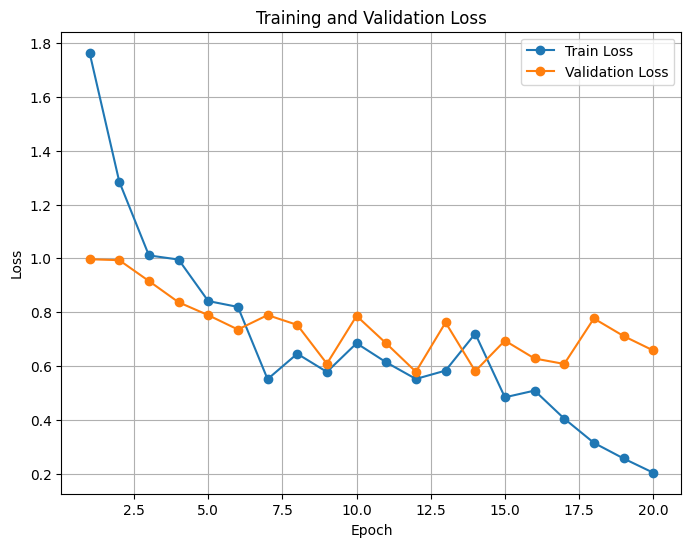

In [57]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define hyperparameters
learning_rate = 0.001
num_epochs = 20

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to evaluate validation loss
def evaluate_validation_loss(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss = evaluate_validation_loss(model, val_loader, criterion)

    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


Q8)Why we have chosen adam optimizer over SGD?

The choice of **Adam optimizer** over **SGD** (Stochastic Gradient Descent) is based on specific advantages that Adam offers, especially in deep learning tasks. Here's a detailed comparison to understand why Adam might be preferred in this case:

---

### 1. **Adaptive Learning Rate**
   - **Adam**: Adam adjusts the learning rate for each parameter dynamically using estimates of the first and second moments of the gradients (mean and variance). This allows it to adaptively scale the learning rate for each parameter, making it suitable for problems where the gradients vary significantly across parameters.
   - **SGD**: SGD uses a fixed learning rate (or a manually adjusted schedule). While this simplicity can be effective, it often requires extensive tuning of the learning rate to ensure convergence.

   **Why Adam?**
   - Adam’s adaptive learning rate eliminates the need to manually tune learning rates for each parameter, making it more efficient and less sensitive to hyperparameter settings.

---

### 2. **Faster Convergence**
   - **Adam**: It combines the benefits of momentum (from RMSprop and Momentum methods) to accelerate convergence. It’s especially effective in scenarios with sparse gradients or complex optimization landscapes.
   - **SGD**: Vanilla SGD can take longer to converge and may oscillate in regions with sharp minima or saddle points.

   **Why Adam?**
   - Faster convergence is critical when training models for a limited number of epochs (like 20 in your case). Adam often achieves reasonable results in fewer iterations compared to SGD.

---

### 3. **Robustness to Hyperparameters**
   - **Adam**: Performs well with default hyperparameters (`learning rate=0.001`, `beta1=0.9`, `beta2=0.999`). This makes it a reliable choice for most tasks without extensive hyperparameter tuning.
   - **SGD**: Requires careful tuning of the learning rate, and additional hyperparameters like momentum must often be configured for optimal results.

   **Why Adam?**
   - Adam is easier to use when you're starting with a new model or dataset since it generally performs well out of the box.

---

### 4. **Sparse Gradients**
   - **Adam**: Works well in cases where the dataset or model results in sparse gradients (e.g., image datasets with background noise or features that rarely activate).
   - **SGD**: Can struggle in these scenarios, as all parameters are updated uniformly without considering the sparsity of gradients.

   **Why Adam?**
   - Adam is better suited for handling sparse gradients, which can occur in convolutional neural networks (CNNs) with certain datasets.

---

### 5. **Use Case of the Task**
   - **Adam**: Typically recommended for deep learning tasks like image classification, where the optimization landscape can be complex and gradients may vary significantly.
   - **SGD**: Often performs well for simpler models or when the optimization landscape is relatively smooth (e.g., shallow networks).

   **Why Adam?**
   - Your task involves a CNN for image classification. These networks often benefit from Adam's ability to handle complex optimization landscapes and sparse activations effectively.

---

### When to Use SGD Instead of Adam?

While Adam is generally a good default choice, there are cases where SGD might be preferred:
1. **Large Datasets and Longer Training Times:** With sufficient training time, SGD (with momentum) often generalizes better than Adam, especially for deep networks.
2. **Fine-Tuning Pretrained Models:** For fine-tuning, SGD is commonly used as it allows more control over learning rate schedules.
3. **Overfitting Concerns:** Adam may overfit more easily due to faster convergence, while SGD with a slower learning rate might improve generalization.

---

### Conclusion

Adam is chosen over SGD in this scenario because:
- It converges faster in fewer epochs.
- It adapts the learning rate automatically, saving tuning effort.
- It handles sparse gradients effectively.
- It’s robust to hyperparameter settings.

However, if you have time and resources, you could experiment with both optimizers and compare their performance. This kind of testing often reveals which optimizer is better suited for your specific task.

Q9)Why we have chosen sparse categorical crossentropy as the loss function?


The choice of **Sparse Categorical Crossentropy** as the loss function is particularly appropriate for multi-class classification tasks where the target labels are **integers** (instead of one-hot encoded vectors). Here's a detailed explanation of why this choice is suitable for your task:

---

### 1. **Nature of the Problem (Multi-Class Classification)**
   - Your task involves classifying images into multiple categories (e.g., different classes of rice diseases). This is a **multi-class classification** problem, where the model needs to predict one label out of several possible classes.
   
### 2. **Target Labels as Integers**
   - **Sparse Categorical Crossentropy** is designed for scenarios where the labels are provided as **integer indices** (e.g., class 0, class 1, class 2, etc.), rather than **one-hot encoded vectors**. In your case, each image is assigned a label corresponding to one of the classes (e.g., class 0, class 1, etc.), and these are typically represented as integer values.

   - **Why not categorical crossentropy?**: If you were to use **Categorical Crossentropy**, the labels would need to be one-hot encoded, which means converting the integer labels (e.g., 0, 1, 2) into one-hot vectors (e.g., [1, 0, 0], [0, 1, 0], etc.). While this approach works fine, it requires additional preprocessing. **Sparse Categorical Crossentropy** directly takes integer labels, eliminating the need for one-hot encoding and simplifying the pipeline.

---

### 3. **Efficiency in Terms of Memory and Computation**
   - One-hot encoding requires a vector that is as large as the number of classes. For example, if there are 10 classes, you need to store a vector of length 10 for each label. With **Sparse Categorical Crossentropy**, the labels are simply integers (e.g., 0, 1, 2), which saves both **memory** and **computation**, especially when the number of classes is large.
   
   - **Sparse Categorical Crossentropy** is thus more **efficient** in terms of memory usage compared to categorical crossentropy when the labels are already integers.

---

### 4. **Behavior of the Loss Function**
   - Both **Categorical Crossentropy** and **Sparse Categorical Crossentropy** work in similar ways but differ in how the target labels are presented:
     - **Categorical Crossentropy**: Works with **one-hot encoded** labels.
     - **Sparse Categorical Crossentropy**: Works with **integer encoded** labels.

   - The loss function computes the **cross-entropy** between the predicted probability distribution and the true label. The model's predictions are a probability distribution across all classes, and the true label is either a one-hot encoded vector (for categorical) or an integer (for sparse categorical). The loss measures how far off the predicted probabilities are from the true class.

---

### 5. **Why Not Other Loss Functions?**
   - **Mean Squared Error (MSE)**: MSE is generally not used for classification problems, especially with discrete classes, because it doesn’t penalize incorrect classifications as effectively as cross-entropy does. Cross-entropy loss has been specifically designed for classification tasks, where the output is a probability distribution, making it more suitable.
   
   - **Binary Crossentropy**: This is used for **binary classification** (two classes). Since your task is multi-class, binary crossentropy would not be appropriate here, as it deals with only two classes at a time.

---

### 6. **General Suitability for Neural Networks**
   - **Sparse Categorical Crossentropy** is one of the most commonly used loss functions for multi-class classification problems in neural networks. It is particularly well-suited for models with a **softmax** output layer (which produces a probability distribution over classes), as it directly compares the predicted probability for the correct class with the ground truth label.

---

### Summary: Why Sparse Categorical Crossentropy?

- **It’s designed for multi-class classification** tasks where the target labels are integer-encoded, which is the case for your problem.
- **It saves memory** and **computational efficiency** because it avoids the need for one-hot encoding of the labels.
- It works seamlessly with the **softmax output layer**, which is common in multi-class classification tasks.

This choice simplifies your workflow, makes the training process more efficient, and aligns with best practices for this type of problem.

Training Accuracy: 0.9306
Test Accuracy: 0.6667


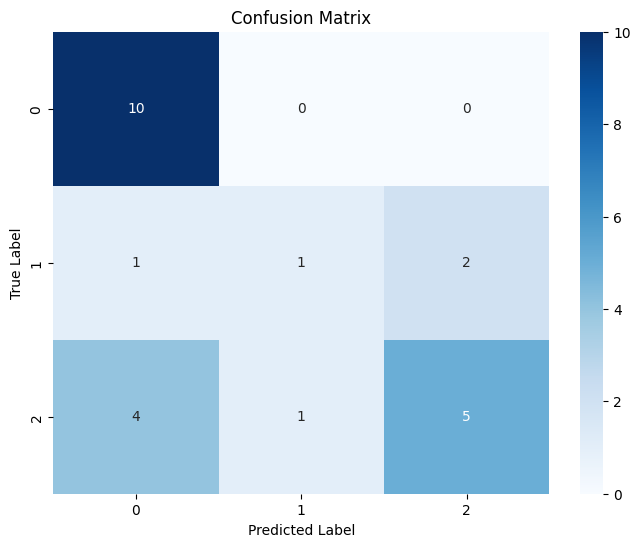

Precision: 0.6587
Recall: 0.6667


In [58]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, all_preds, all_labels

# Evaluate on training data
train_accuracy, train_preds, train_labels = calculate_accuracy(train_loader, model)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on test data
test_accuracy, test_preds, test_labels = calculate_accuracy(test_loader, model)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(K), yticklabels=np.arange(K))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Precision and Recall
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01
Training with learning rate: 0.1


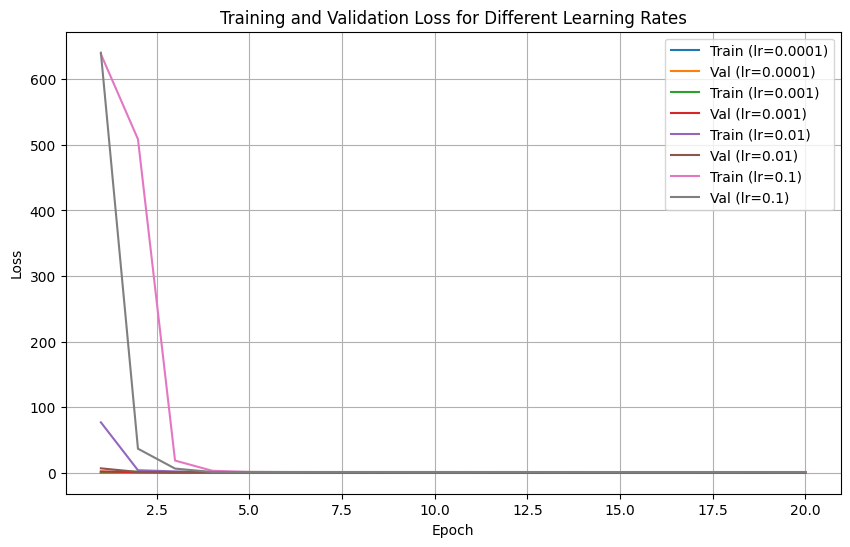

In [59]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Function to train the model and track losses
def train_model_with_lr(learning_rate, model, train_loader, val_loader, num_epochs=20):
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Lists to store the loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()

        # Average train loss for this epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses

# Learning rates to experiment with
learning_rates = [0.0001, 0.001, 0.01, 0.1]
train_loss_dict = {}
val_loss_dict = {}

# Train the model for each learning rate and store the losses
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    train_losses, val_losses = train_model_with_lr(lr, model, train_loader, val_loader)
    train_loss_dict[lr] = train_losses
    val_loss_dict[lr] = val_losses

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    plt.plot(range(1, 21), train_loss_dict[lr], label=f'Train (lr={lr})')
    plt.plot(range(1, 21), val_loss_dict[lr], label=f'Val (lr={lr})')

plt.title('Training and Validation Loss for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
